In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import scipy.io.wavfile
import scipy.signal
import wave, struct
import pandas as pd
from scipy.signal import butter, freqz, filtfilt
from scipy.signal import find_peaks
from scipy.fft import rfft, fft, fftfreq, rfftfreq
from scipy import stats
from sklearn.metrics import confusion_matrix
import seaborn as sns
import glob, os
from tensorflow import keras
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore')


### 20 Hz (20 samples per second).
### Window Size: 3 seconds (60) and Step Size: 1 second (20).
#### 33% overlap.
Initiaized the variables and models.

In [43]:
# 20 samples per second
sampling_rate = 20
# 1 sec step size
step_size = 20
# 3 sec windows 
window_size = 60

model = keras.Sequential(
    [keras.layers.Dense(100,input_shape=(140,), activation='relu'),
     keras.layers.Dense(6, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

cv = KFold(n_splits=10, random_state=1, shuffle=True)

ss = StandardScaler()

lr = LogisticRegression(random_state = 0)

knn = KNeighborsClassifier(n_neighbors=6)

target_names = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']

## The "window" function gets a dataset, converts it to windows (overlapping or non-overlapping) of the given window size and step size.
### Then, using the "get_time_series_features" & "get_freq_domain_features" functions, it gets the features for the window and concatenates both the dataframes into one.

In [3]:
def window(data,window_size,step_size):

    window_ft = []
    time_ft = []
    freq_ft = []
    i=0
    while i + window_size < len(data) + 1:
        window_array = data[i:i+window_size]
        time_ft = get_time_series_features(window_array)
        freq_ft = get_freq_domain_features(window_array)
        con = np.concatenate((time_ft, freq_ft))
        window_ft.append(con)
        i=i+step_size
                 
    return np.array(window_ft)


## The "get_activity_user" gets a detaset, converts it into windows and returns the value with the maximum value count in the particular window as its features.

In [4]:
def get_activity_user(data,window_size,step_size):
    
    window_ft = []
    i=0
    while i + window_size < len(data) + 1:
        window_array = data[i:i+window_size]
        window_ft.append(np.array(window_array.value_counts().head(1).index))
        i=i+step_size
    return np.array(window_ft)


## The "create_data" function gets the raw dataset and then extracts the time and frequency domain features on the windows.
### Gets the user specific column and activity label.
### Concatenates all the datasets and creates a single dataset with features extracted.

In [5]:
def create_data(ds):
    activity_ds = ds.pop("activity")
    user_ds = ds.pop("user")
    user = get_activity_user(user_ds,window_size,step_size)
    ds.astype(str).astype(float)
    act_ft = get_activity_user(activity_ds,window_size,step_size)
    mag_ft = window(ds.mag,window_size,step_size)
    x_ft = window(ds["x-axis"],window_size,step_size)
    y_ft = window(ds["x-axis"],window_size,step_size)
    z_ft = window(ds["z-axis"],window_size,step_size)
    act_ft.astype(str).astype(str)
#     x = np.concatenate((mag_ft,x_ft,y_ft,z_ft,user),axis=1)
    all_ft = np.concatenate((mag_ft,x_ft,y_ft,z_ft,act_ft,user),axis=1)

    return pd.DataFrame(all_ft)


## The "leave_one_subject_cross_val" function gets the dataset and the users list.
### Using a pipeline with StandardScaler and Logistic Regression, it takes one subject/user at a time as the testing data. 
### Others as training data and returns a DataFrame with the Accuracy scores for each user.

In [6]:
def leave_one_subject_cross_val(data,users):

    pipe = Pipeline([('scaler', ss), ("logistic", lr)])
    score_array = []
    for user in users:
        test_data = data[data[141]==user]
        train_data = data[data[141]!=user]
    
        y_test = test_data[140]
        x_test = test_data.iloc[:,:140]
   
        y_train = train_data[140]
        x_train = train_data.iloc[:,:140]
    
        pipe.fit(x_train,y_train)
        score = pipe.score(x_test,y_test)

        score_array.append([user,score])   

    return pd.DataFrame(score_array)

## The "leave_one_subject_cross_val" function gets the dataset, the users list and group size.
### It separates the data into non-overlapping groups of the input size.
### Then, the cross validata accuracy scores are return along with user list's index.

In [7]:
def leave_one_group_out_cross_val(data,users,group_size):
    test_df = pd.DataFrame()
    train_df = pd.DataFrame()
    i=0
    pipe = Pipeline([('scaler', ss), ("logistic", lr)])
    score_array = []
    
    while i + group_size < len(users) + 1:
        user_test = users[i:i+group_size]
        user_train = users[i+group_size:]
        
        for u in user_test:
            test_data = data[data[141]==u]
            test_df = pd.concat([test_df,test_data],axis=0)
            
        y_test = test_df[140]
        x_test = test_df.iloc[:,:140]    
        
        for u in user_train:
            train_data = data[data[141]==u]
            train_df = pd.concat([train_df,train_data],axis=0)
            
        y_train = train_df[140]
        x_train = train_df.iloc[:,:140] 
    
        pipe.fit(x_train,y_train)
        score = pipe.score(x_test,y_test)
        
        score_array.append([i,score]) 
        
        i=i+group_size


    return pd.DataFrame(score_array)

## The "create_train_test" gets the dataset and user list.
### It returns the first 28 participants' data as training data and the rest as testing data.

In [8]:
def create_train_test(data,users):
    
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    
    for user in users:
        t = data[data[141]==user]

        if user<29:
            train_df = pd.concat([train_df,t],axis=0) 
        else:
            test_df = pd.concat([test_df,t],axis=0)
    
    y_train = train_df[140]
    x_train = train_df.iloc[:,:140]
    
    y_test = test_df[140]
    x_test = test_df.iloc[:,:140]
      
    return x_train,x_test,y_train,y_test

## The "get_time_series_features" and "get_freq_domain_features" functions as given in the CS7390 course.

In [9]:
def get_time_series_features(signal):
    window_size = len(signal)
    
    sig_mean = np.mean(signal)
    # standard deviation
    sig_std = np.std(signal)
    # avg absolute difference
    sig_aad = np.mean(np.absolute(signal - np.mean(signal)))
    # min
    sig_min = np.sort(signal)[0]
    # max
    sig_max = np.sort(signal)[len(signal)-1]
    # max-min difference
    sig_maxmin_diff = sig_max - sig_min
    # median
    sig_median = np.median(signal)
    # median absolute deviation
    sig_mad = np.median(np.absolute(signal - np.median(signal)))
    # Inter-quartile range
    sig_IQR = np.percentile(signal, 75) - np.percentile(signal, 25)
    # negative count
    sig_neg_count = np.sum(s < 0 for s in signal)
    # positive count
    sig_pos_count = np.sum(s > 0 for s in signal)
    # values above mean
    sig_above_mean = np.sum(s > sig_mean for s in signal)
    # number of peaks
    sig_num_peaks = len(find_peaks(signal)[0])
    # skewness
    sig_skew = stats.skew(signal)
    # kurtosis
    sig_kurtosis = stats.kurtosis(signal)
    # energy
    sig_energy = np.sum(s ** 2 for s in signal) / window_size
    # signal area
    sig_sma = np.sum(signal) / window_size

    return [sig_mean, sig_std, sig_aad, sig_min, sig_max, sig_maxmin_diff, sig_median, sig_mad, sig_IQR, sig_neg_count, sig_pos_count, sig_above_mean, sig_num_peaks, sig_skew, sig_kurtosis, sig_energy, sig_sma]

def get_freq_domain_features(signal):
    all_fft_features = []
    window_size = len(signal)
    signal_fft = np.abs(np.fft.fft(signal))
    # Signal DC component
    sig_fft_dc = signal_fft[0]
    # aggregations over the fft signal
    fft_feats = get_time_series_features(signal_fft[1:int(window_size / 2) + 1])

    all_fft_features.append(sig_fft_dc)
    all_fft_features.extend(fft_feats)
    return all_fft_features


## The csv file is read into a DataFrame.
### Users list contains the user id.

In [10]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv("/Users/sohinib/Downloads/WISDM_ar_v1.1 3/WISDM_ar_v1.1_raw.txt",sep='\t', header = None, names = columns)
df = df.dropna()
users = df.user.value_counts().index
print("Users: ",np.array(users))
df.head()

Users:  [20. 31.  8. 29. 14. 13. 34. 32. 21.  3. 27. 10. 18. 12. 26. 36. 11.  1.
  6. 33.  5. 15.  7. 24. 23. 30.  2. 35. 22. 17. 28. 16. 25.  9.  4.]


,user,activity,timestamp,x-axis,y-axis,z-axis
0,33.0,Jogging,4.910600e+13,-0.694638,12.680544,0.503953
1,33.0,Jogging,4.910610e+13,5.012288,11.264028,0.953424
2,33.0,Jogging,4.910610e+13,4.903325,10.882658,-0.081722
3,33.0,Jogging,4.910620e+13,-0.612916,18.496431,3.023717
4,33.0,Jogging,4.910630e+13,-1.184970,12.108489,7.205164


## A new column "mag", for the magnitude of the 3 axes, is added.
### The "timestamp" column is dropped.

In [11]:
df["mag"] = np.sqrt(df["x-axis"]*df["x-axis"]+df["y-axis"]*df["y-axis"]+df["z-axis"]*df["z-axis"])
df = df.drop(["timestamp"],axis=1)
df

,user,activity,x-axis,y-axis,z-axis,mag
0,33.0,Jogging,-0.694638,12.680544,0.503953,12.709551
1,33.0,Jogging,5.012288,11.264028,0.953424,12.365693
2,33.0,Jogging,4.903325,10.882658,-0.081722,11.936562
3,33.0,Jogging,-0.612916,18.496431,3.023717,18.751973
4,33.0,Jogging,-1.184970,12.108489,7.205164,14.139804
...,...,...,...,...,...,...
1048571,7.0,Standing,-8.120000,5.520000,-0.800000,9.851132
1048572,7.0,Standing,-7.890000,5.790000,-0.720000,9.812981
1048573,7.0,Standing,-7.890000,5.980000,-0.270000,9.903807
1048574,7.0,Standing,-8.120000,5.630000,-0.890000,9.920857


## The features extraction is done on the raw data, using windows & steps.

In [12]:
data = create_data(df)
data

,0,1,2,3,4,5,6,7,8,9,...,132,133,134,135,136,137,138,139,140,141
0,11.707964,6.223843,5.440427,1.103248,21.746053,20.642805,12.159107,5.293934,10.515005,0.0,...,0.0,30.0,14.0,10.0,1.691964,4.048034,1518.354265,33.659389,Jogging,33.0
1,11.635821,6.497524,5.788215,1.103248,21.746053,20.642805,11.618769,5.841323,11.691456,0.0,...,0.0,30.0,10.0,10.0,1.170275,0.91921,1332.684486,31.457022,Jogging,33.0
2,11.873059,6.26141,5.507278,1.103248,21.746053,20.642805,11.664102,5.442577,10.936315,0.0,...,0.0,30.0,16.0,11.0,-0.084655,-0.440639,1430.227803,34.73189,Jogging,33.0
3,11.236661,6.079379,5.220032,1.648456,21.312032,19.663576,10.891962,5.562835,10.957571,0.0,...,0.0,30.0,14.0,8.0,0.391092,-0.476747,1470.508006,33.942248,Jogging,33.0
4,11.344601,6.398381,5.629877,1.648456,22.348409,20.699953,10.891962,5.678971,11.510567,0.0,...,0.0,30.0,14.0,9.0,0.036171,-1.364484,1443.053124,33.235677,Jogging,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52421,9.805347,0.277019,0.188028,9.234555,11.052176,1.817622,9.767515,0.114168,0.233462,0.0,...,0.0,30.0,12.0,10.0,1.330884,1.468839,15.17226,3.167371,Standing,7.0
52422,9.81175,0.23427,0.144653,9.234555,11.052176,1.817622,9.786153,0.09507,0.187698,0.0,...,0.0,30.0,11.0,9.0,1.698068,2.328747,11.196367,2.449903,Standing,7.0
52423,9.861004,0.222745,0.164518,9.356009,10.586836,1.230827,9.808665,0.107598,0.236586,0.0,...,0.0,30.0,9.0,11.0,1.326795,0.377635,10.682447,2.391412,Standing,7.0
52424,9.84827,0.284377,0.218199,9.276168,10.586836,1.310668,9.805748,0.164801,0.333817,0.0,...,0.0,30.0,13.0,8.0,2.157609,6.181975,12.913233,2.621135,Standing,7.0


## Leave one subject/user out cross validation scores (accuracy measure).
### Index represents user id.

In [13]:
score_leave_one_subject = leave_one_subject_cross_val(data,users)
score_leave_one_subject.set_index(score_leave_one_subject[0],inplace=True)
score_leave_one_subject.drop([0],axis=1,inplace=True)
score_leave_one_subject

,1
0,
20.0,0.947368
31.0,0.899729
8.0,0.902913
29.0,0.832113
14.0,0.848691
13.0,0.904582
34.0,0.849750
32.0,0.889077
21.0,0.809255


## Leave one group out cross validation scores (accuracy measure).
### Index represents group id (according to the users list index).
### Here, group size has been taken as 3.

In [14]:
scores_leave_one_group = leave_one_group_out_cross_val(data,users,3)
scores_leave_one_group.set_index(scores_leave_one_group[0],inplace=True)
scores_leave_one_group.drop([0],axis=1,inplace=True)
scores_leave_one_group

,1
0,
0,0.910626
3,0.893992
6,0.890274
9,0.891004
12,0.888005
15,0.883056
18,0.885531
21,0.882222
24,0.879497


## Getting x_train,x_test,y_train,y_test to feed into the models.

In [15]:
x_train,x_test,y_train,y_test = create_train_test(data,users)

In [16]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(39257, 140)
(39257,)
(13169, 140)
(13169,)


## Using StandardScaler() to scale the values, before putting it through the neural netowrk.

In [17]:
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.transform(x_test)

## 'Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'

In [18]:
a = np.array(y_train)
a = pd.DataFrame(a)
a.replace({'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5},inplace=True)
a_train = np.array(a)
b = np.array(y_test)
b = pd.DataFrame(b)
b.replace({'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5},inplace=True)
a_test = np.array(b)

## Neural Network Model
#### input shape: 140
#### 1st layer:   activation -> relu;   100 nodes
#### 2nd layer:   activation -> sigmoid;   6
#### loss:  sparse_categorical_crossentropy, optimizer:  adam, metrics:  accuracy

#### epochs: 30, batch_size: 3

In [44]:
model.fit(x_train_ss,a_train,epochs=30,batch_size=3) 
# BEST

Epoch 1/30
13086/13086 [==============================] - 21s 2ms/step - loss: 0.2656 - accuracy: 0.9060
Epoch 2/30
13086/13086 [==============================] - 20s 2ms/step - loss: 0.1838 - accuracy: 0.9353
Epoch 3/30
13086/13086 [==============================] - 27s 2ms/step - loss: 0.1637 - accuracy: 0.9432
Epoch 4/30
13086/13086 [==============================] - 23s 2ms/step - loss: 0.1480 - accuracy: 0.9486
Epoch 5/30
13086/13086 [==============================] - 23s 2ms/step - loss: 0.1381 - accuracy: 0.9535
Epoch 6/30
13086/13086 [==============================] - 27s 2ms/step - loss: 0.1311 - accuracy: 0.9559
Epoch 7/30
13086/13086 [==============================] - 24s 2ms/step - loss: 0.1243 - accuracy: 0.9582
Epoch 8/30
13086/13086 [==============================] - 33s 3ms/step - loss: 0.1229 - accuracy: 0.9597
Epoch 9/30
13086/13086 [==============================] - 26s 2ms/step - loss: 0.1133 - accuracy: 0.9611
Epoch 10/30
13086/13086 [==============================

In [45]:
# scores_nn = cross_val_score(model, x_train_ss, a_train, scoring='accuracy', cv=cv)

In [46]:
model.evaluate(x_test_ss,a_test)

412/412 [==============================] - 1s 1ms/step - loss: 2.6049 - accuracy: 0.7948


[2.6049416065216064, 0.7948211431503296]

#### The classification report is given below.
#### Accuracy: 83%

In [47]:
y_pred_nn = [np.argmax(i) for i in model.predict(x_test_ss)]
print("nn model")
print(classification_report(a_test, y_pred_nn, target_names=target_names))

nn model
              precision    recall  f1-score   support

     Walking       0.87      0.78      0.83      4795
     Jogging       0.85      0.93      0.89      3973
    Upstairs       0.59      0.61      0.60      1456
  Downstairs       0.52      0.53      0.52      1298
     Sitting       0.79      1.00      0.88       899
    Standing       0.98      0.70      0.81       748

    accuracy                           0.79     13169
   macro avg       0.77      0.76      0.76     13169
weighted avg       0.80      0.79      0.79     13169



## Confusion Matrix NN

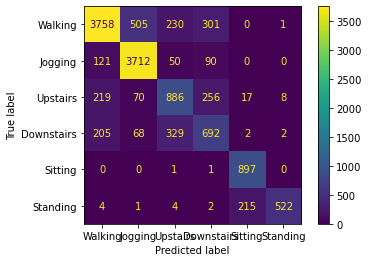

In [48]:
cm_nn = confusion_matrix(a_test, y_pred_nn)
cm_nn_display= metrics.ConfusionMatrixDisplay(confusion_matrix = cm_nn, display_labels = target_names)
cm_nn_display.plot()

## Logistic Regression
#### Used a pipeline with StandardScaler.
#### The classification report is given below.
#### Accuracy: 81%

In [23]:
pipe = Pipeline([('scaler', ss), ("logistic", lr)])
pipe.fit(x_train,y_train)
y_pred_lr = pipe.predict(x_test)
print("Accuracy: " + str(pipe.score(x_test,y_test)))
print("logistic regression")
print(classification_report(y_test, y_pred_lr, target_names=target_names))

Accuracy: 0.807502467917078
logistic regression
              precision    recall  f1-score   support

     Walking       0.62      0.58      0.60      1298
     Jogging       0.88      0.95      0.91      3973
    Upstairs       0.71      1.00      0.83       899
  Downstairs       0.96      0.79      0.87       748
     Sitting       0.64      0.53      0.58      1456
    Standing       0.84      0.81      0.82      4795

    accuracy                           0.81     13169
   macro avg       0.78      0.77      0.77     13169
weighted avg       0.81      0.81      0.80     13169



## 10 Fold Cross Val 

In [24]:
scores_lr = cross_val_score(lr, x_train, y_train, scoring='accuracy', cv=cv)
scores_lr

array([0.81100357, 0.80820173, 0.81813551, 0.80718288, 0.81253184,
       0.81100357, 0.81507896, 0.80942675, 0.80203822, 0.80713376])

## Confusion Matrix Logistic Regression

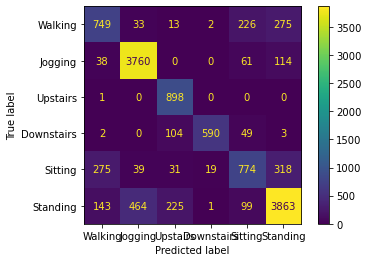

In [25]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr_display= metrics.ConfusionMatrixDisplay(confusion_matrix = cm_lr, display_labels = target_names)
cm_lr_display.plot()

## K-NN
#### Used a pipeline with StandardScaler.
#### The classification report is given below.
#### Accuracy: 81%

In [26]:
pipe = Pipeline([('scaler', ss), ("knn", knn)])
pipe.fit(x_train,y_train)
y_pred_knn = pipe.predict(x_test)
print("Accuracy: " + str(pipe.score(x_test,y_test)))
print("k nearest neighbour")
print(classification_report(y_test, y_pred_knn, target_names=target_names))

Accuracy: 0.8103880325005696
k nearest neighbour
              precision    recall  f1-score   support

     Walking       0.51      0.51      0.51      1298
     Jogging       0.92      0.91      0.91      3973
    Upstairs       0.88      0.92      0.90       899
  Downstairs       0.90      0.85      0.87       748
     Sitting       0.55      0.50      0.52      1456
    Standing       0.85      0.88      0.86      4795

    accuracy                           0.81     13169
   macro avg       0.77      0.76      0.76     13169
weighted avg       0.81      0.81      0.81     13169



## 10 Fold Cross Val 

In [27]:
scores_knn = cross_val_score(knn, x_train, y_train, scoring='accuracy', cv=cv)
scores_knn

array([0.90269995, 0.90601121, 0.91492613, 0.90855833, 0.90091696,
       0.90957718, 0.90652063, 0.90038217, 0.91617834, 0.90165605])

## Confusion Matrix K-NN

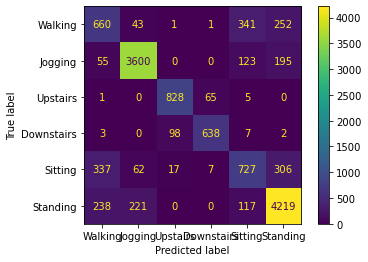

In [28]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn_display= metrics.ConfusionMatrixDisplay(confusion_matrix = cm_knn, display_labels = target_names)
cm_knn_display.plot()